In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, KFold


# the below extension properly formats a cell after it is run
%load_ext nb_black

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option("display.max_columns", 200)

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [29]:
housing = pd.read_csv("../data/housing_corr.csv")

<IPython.core.display.Javascript object>

In [30]:
# Dropping columns not needed
housing.drop(
    ["PID", "Neighborhood_st"], axis=1, inplace=True,
)

<IPython.core.display.Javascript object>

## Oridinal categorical data was already encoded properly in a previous notebook.   This is an important step we took since SHAP values wont be properly calculated otherwise.  Ordinal encoding was used for the remaining nominal categorical data.

In [32]:
# get a list of categorical features (i.e., object type columns)
cat_features = list(housing.select_dtypes(include=["object"]).columns)


<IPython.core.display.Javascript object>

In [33]:
from sklearn.preprocessing import OrdinalEncoder

# create an instance of the OrdinalEncoder class
ordinal_encoder = OrdinalEncoder()


# fit the ordinal encoder to the categorical features
ordinal_encoder.fit(housing[cat_features])

# transform the categorical features into encoded numerical values
housing[cat_features] = ordinal_encoder.transform(housing[cat_features])

<IPython.core.display.Javascript object>

## Looking for high high cardinality which could affect model output

In [9]:
for name in housing.columns:
    print(name, ": number of values", len(housing[name].value_counts()))

SalePrice : number of values 914
MSZoning : number of values 6
LotFrontage : number of values 127
LotArea : number of values 1741
Street : number of values 2
Alley : number of values 3
LotShape : number of values 4
LandContour : number of values 4
Utilities : number of values 2
LotConfig : number of values 5
LandSlope : number of values 3
Neighborhood : number of values 26
Condition1 : number of values 9
Condition2 : number of values 8
BldgType : number of values 5
HouseStyle : number of values 8
OverallQual : number of values 10
OverallCond : number of values 9
RoofStyle : number of values 6
RoofMatl : number of values 7
Exterior1st : number of values 15
Exterior2nd : number of values 16
MasVnrType : number of values 4
MasVnrArea : number of values 414
ExterCond : number of values 5
Foundation : number of values 6
BsmtQual : number of values 6
BsmtCond : number of values 6
BsmtExposure : number of values 5
BsmtFinSF1 : number of values 924
BsmtFinSF2 : number of values 262
BsmtUnfSF :

<IPython.core.display.Javascript object>

## Creating bins to deal with high cardinality

## Deciding on optimal bins for each variable with high cardinality

In [14]:
# Helper function for binning
def bin_variable(df, var, num_bins):
    binned_var = pd.qcut(df[var], q=num_bins, duplicates='drop', labels=False)
    return binned_var


<IPython.core.display.Javascript object>

In [16]:
# Function to evaluate model performance or different bin sizes

def evaluate_binning(df, var, num_bins, target):
    temp_df = df.copy()
    temp_df[f"{var}_binned"] = bin_variable(temp_df, var, num_bins)
    temp_df = temp_df.drop(var, axis=1)

    model = RandomForestRegressor(random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, temp_df, target, cv=kf, scoring='neg_mean_squared_error')
    return -1 * scores.mean()


<IPython.core.display.Javascript object>

In [17]:
# Determining the optimal bin size (takes over 30 minutes to run)

variables = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalOutdoorSF', 'Age', 'RemodAge', 'TotalSF']
target = housing['SalePrice']

bin_range = list(range(2, 21))  # Test bin sizes from 2 to 20
optimal_bins = {}

for var in variables:
    best_num_bins = 2
    best_score = float('inf')

    for num_bins in bin_range:
        score = evaluate_binning(housing, var, num_bins, target)
        if score < best_score:
            best_score = score
            best_num_bins = num_bins

    optimal_bins[var] = best_num_bins
    print(f"Optimal bin size for {var}: {best_num_bins}")


Optimal bin size for LotArea: 19
Optimal bin size for MasVnrArea: 12
Optimal bin size for BsmtFinSF1: 10
Optimal bin size for BsmtFinSF2: 13
Optimal bin size for BsmtUnfSF: 11
Optimal bin size for TotalOutdoorSF: 4
Optimal bin size for Age: 13
Optimal bin size for RemodAge: 3
Optimal bin size for TotalSF: 16


<IPython.core.display.Javascript object>

In [18]:
# Applying optimal bin size
for var, num_bins in optimal_bins.items():
    housing[f"{var}_binned"] = bin_variable(housing, var, num_bins)
    housing = housing.drop(var, axis=1)  # Dropping the original variable


<IPython.core.display.Javascript object>

In [26]:
# Saving so i dont have to run above code again
housing.to_csv("../data/housing_bins.csv", index=False, encoding="utf-8")

<IPython.core.display.Javascript object>

In [34]:
# Creating features and target variable
housing_data = housing.iloc[:, 1:]
housing_target = housing.iloc[:, 0]

<IPython.core.display.Javascript object>

In [35]:
# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    housing_data, housing_target, test_size=0.2, random_state=0
)

<IPython.core.display.Javascript object>

- The following **get_error** function accepts the train/test features/labels and a classifier model and then it 
does the following
    - fit the model using train set
    - print out the train/test errors
    - return the train/test errors

In [42]:


# from sklearn import ensemble
from sklearn.metrics import mean_squared_error

randomForest = ensemble.RandomForestRegressor()

# fit RF model on training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train, y_train)

# Calculate the mean squared error for the train and test sets
mse_train = mean_squared_error(y_train, randomForest.predict(X_train))
mse_test = mean_squared_error(y_test, randomForest.predict(X_test))

print("The training error (MSE) is: %.5f" % mse_train)
print("The test     error (MSE) is: %.5f" % mse_test)



The training error (MSE) is: 86564007.61137
The test     error (MSE) is: 481514412.54876


<IPython.core.display.Javascript object>

Using the function model_selection.GridSearchCV to find the best parameters. 

In [43]:
# from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Create a RandomForestRegressor object
rf = ensemble.RandomForestRegressor(random_state=0)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/Users/jasonphillip/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   4.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=   0.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   3.1s
[CV] END max_depth=Non

Best parameters found by GridSearchCV:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


<IPython.core.display.Javascript object>

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, ma

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END max_depth=20, max_features=sqrt, min_s

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.9s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.3s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.2s
[CV] END max_depth=None, ma

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   3.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   3.0s
[CV] END max_depth=None, ma

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=10; total time=   0.1s
[CV] END max_depth=None, ma

In [44]:
# Create and fit a RandomForestRegressor model with the best parameters found
best_rf = ensemble.RandomForestRegressor(**grid_search.best_params_, random_state=0)
best_rf.fit(X_train, y_train)

# Calculate the mean squared error for the train and test sets
mse_train_best = mean_squared_error(y_train, best_rf.predict(X_train))
mse_test_best = mean_squared_error(y_test, best_rf.predict(X_test))

print("The training error (MSE) with best parameters is: %.5f" % mse_train_best)
print("The test     error (MSE) with best parameters is: %.5f" % mse_test_best)


The training error (MSE) with best parameters is: 87894953.42642
The test     error (MSE) with best parameters is: 499990578.24155


<IPython.core.display.Javascript object>

In [45]:
from sklearn.metrics import r2_score

# Calculate R-squared for the train and test sets
r2_train_best = r2_score(y_train, best_rf.predict(X_train))
r2_test_best = r2_score(y_test, best_rf.predict(X_test))

print("The training R-squared with best parameters is: %.5f" % r2_train_best)
print("The test     R-squared with best parameters is: %.5f" % r2_test_best)


The training R-squared with best parameters is: 0.98399
The test     R-squared with best parameters is: 0.91743


<IPython.core.display.Javascript object>

Looking for irrelevant or redundant feature using a feature selection
technique Recursive Feature Elimination (RFE) with cross-validation.

In [47]:
from sklearn.feature_selection import RFECV

# Instantiate a RandomForestRegressor with the best parameters
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)

# Perform RFE with cross-validation
selector = RFECV(best_rf, step=1, cv=5, scoring='neg_mean_squared_error')
selector = selector.fit(X_train, y_train)

# Transform the train and test sets
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train the model with selected features
best_rf.fit(X_train_selected, y_train)

# Calculate R-squared for the train and test sets with selected features
r2_train_selected = r2_score(y_train, best_rf.predict(X_train_selected))
r2_test_selected = r2_score(y_test, best_rf.predict(X_test_selected))

print("The training R-squared with selected features is: %.5f" % r2_train_selected)
print("The test     R-squared with selected features is: %.5f" % r2_test_selected)


The training R-squared with selected features is: 0.98563
The test     R-squared with selected features is: 0.92111


<IPython.core.display.Javascript object>

## Looking at Feature Importance

In [55]:
import eli5
from eli5.sklearn import PermutationImportance

# Fit a Permutation Importance estimator
perm = PermutationImportance(best_rf, random_state=42).fit(X_test_selected, y_test)

# Show the feature importances with eli5
eli5.show_weights(perm, feature_names=selected_columns.tolist())


NameError: name 'selected_columns' is not defined

<IPython.core.display.Javascript object>

In [61]:
# # Drop the target column
# X = housing.drop("SalePrice", axis=1)
# y = housing["SalePrice"]

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

<IPython.core.display.Javascript object>

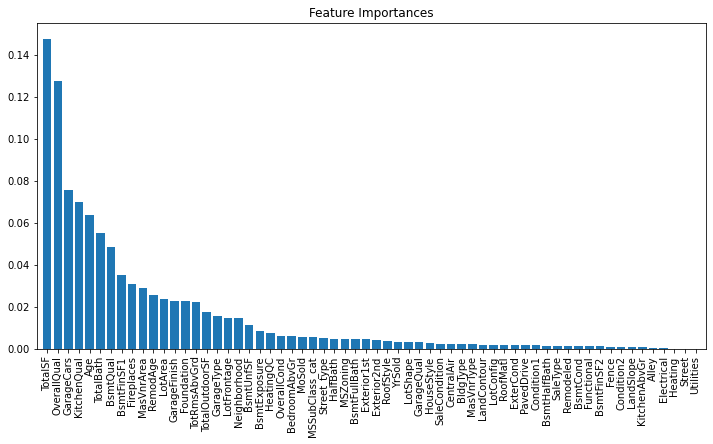

<IPython.core.display.Javascript object>

In [63]:
# Train a RandomForestRegressor with the best parameters on the entire feature set
full_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
full_rf.fit(X_train, y_train)

# Get feature importances
importances = full_rf.feature_importances_

# Sort the indices of importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Create a bar plot of feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[sorted_indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


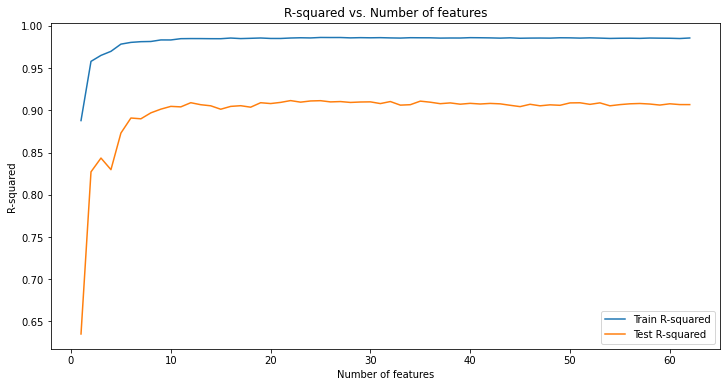

<IPython.core.display.Javascript object>

In [64]:
# graphing the number of features not using the best parameters defined earlier

# Initialize lists to store R-squared values for train and test sets
train_r2 = []
test_r2 = []

# Iterate over the range of feature counts from 1 to the total number of features
for num_features in range(1, X_train.shape[1] + 1):
    
    # Get the indices of the top num_features most important features
    top_features = sorted_indices[:num_features]
    
    # Select the top features for train and test sets
    X_train_top = X_train.iloc[:, top_features]
    X_test_top = X_test.iloc[:, top_features]
    
    # Train a random forest model with the best parameters using the top features
    rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    rf.fit(X_train_top, y_train)
    
    # Calculate R-squared for train and test sets
    train_r2.append(r2_score(y_train, rf.predict(X_train_top)))
    test_r2.append(r2_score(y_test, rf.predict(X_test_top)))

# Plot R-squared values for train and test sets
plt.figure(figsize=(12, 6))
plt.plot(range(1, X_train.shape[1] + 1), train_r2, label="Train R-squared")
plt.plot(range(1, X_train.shape[1] + 1), test_r2, label="Test R-squared")
plt.xlabel("Number of features")
plt.ylabel("R-squared")
plt.title("R-squared vs. Number of features")
plt.legend()
plt.show()


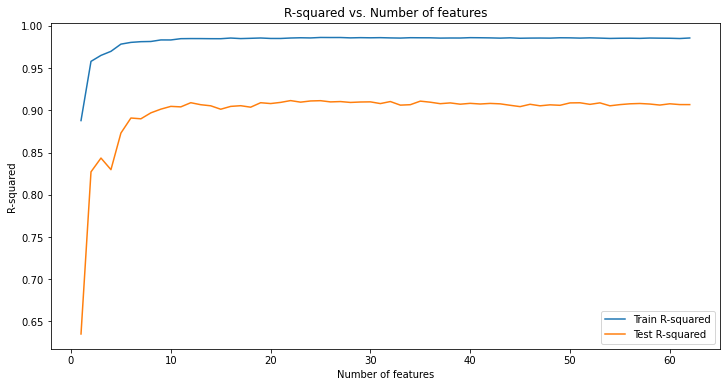

<IPython.core.display.Javascript object>

In [65]:
# Now using the best parameters

# Initialize lists to store R-squared values for train and test sets
train_r2 = []
test_r2 = []

# Iterate over the range of feature counts from 1 to the total number of features
for num_features in range(1, X_train.shape[1] + 1):
    
    # Get the indices of the top num_features most important features
    top_features = sorted_indices[:num_features]
    
    # Select the top features for train and test sets
    X_train_top = X_train.iloc[:, top_features]
    X_test_top = X_test.iloc[:, top_features]
    
    # Train a random forest model with the best parameters using the top features
    rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    rf.fit(X_train_top, y_train)
    
    # Calculate R-squared for train and test sets
    train_r2.append(r2_score(y_train, rf.predict(X_train_top)))
    test_r2.append(r2_score(y_test, rf.predict(X_test_top)))

# Plot R-squared values for train and test sets
plt.figure(figsize=(12, 6))
plt.plot(range(1, X_train.shape[1] + 1), train_r2, label="Train R-squared")
plt.plot(range(1, X_train.shape[1] + 1), test_r2, label="Test R-squared")
plt.xlabel("Number of features")
plt.ylabel("R-squared")
plt.title("R-squared vs. Number of features")
plt.legend()
plt.show()


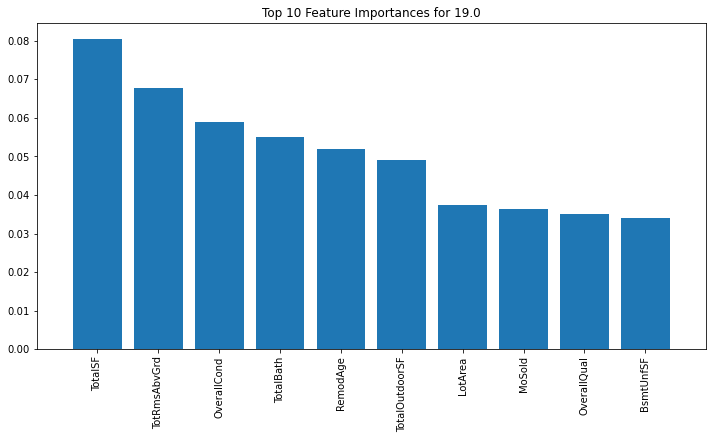

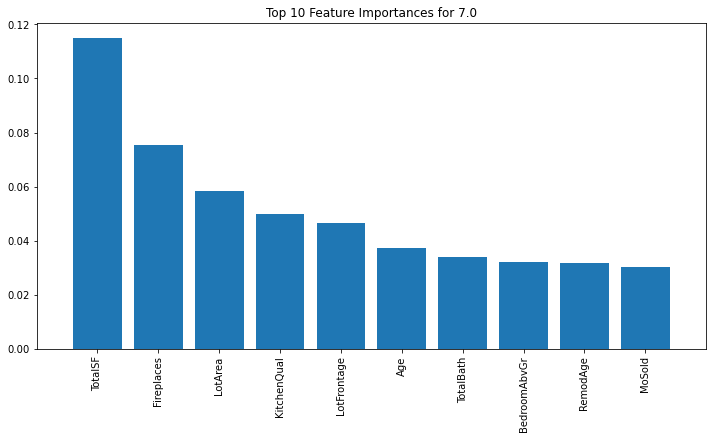

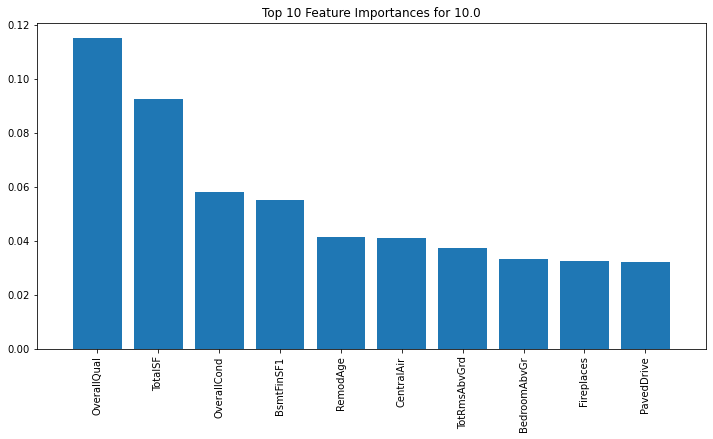

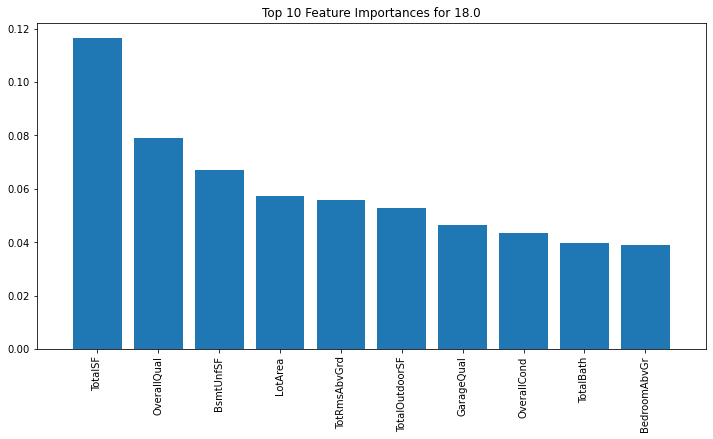

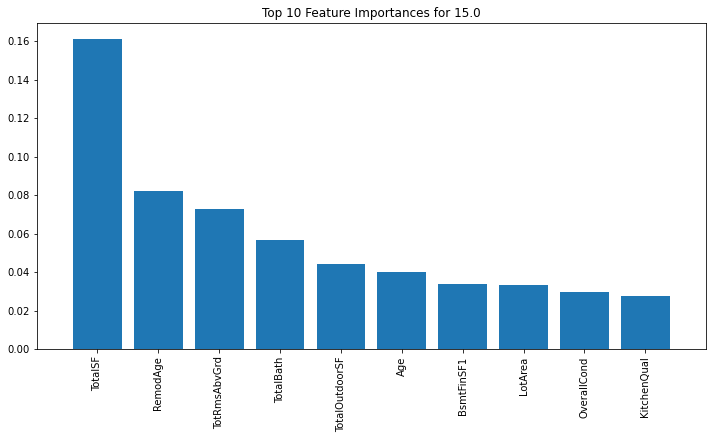

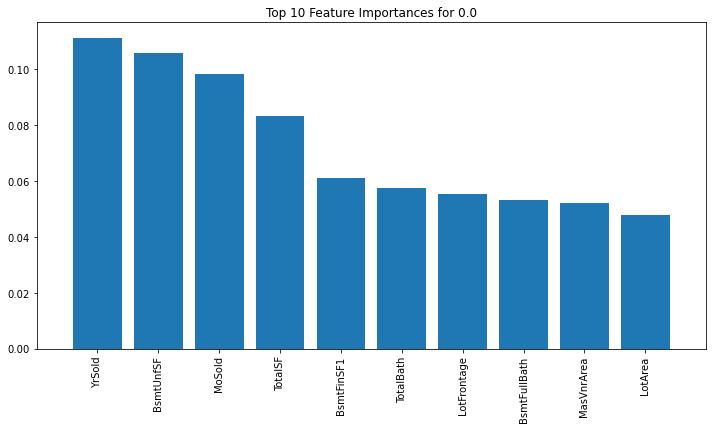

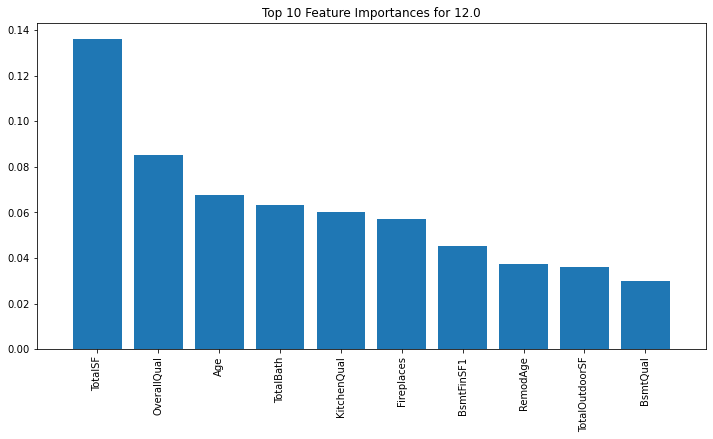

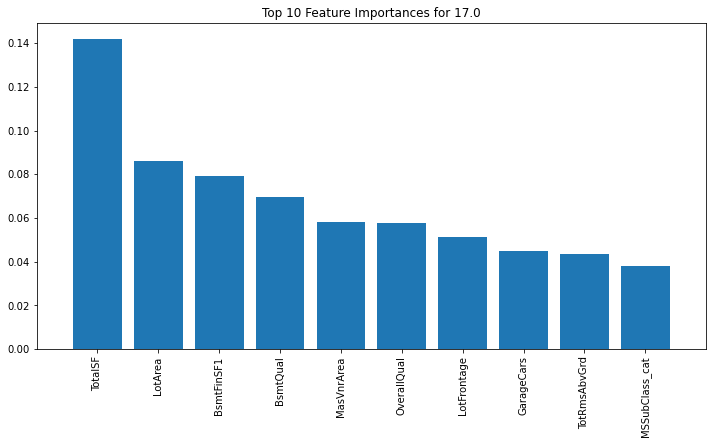

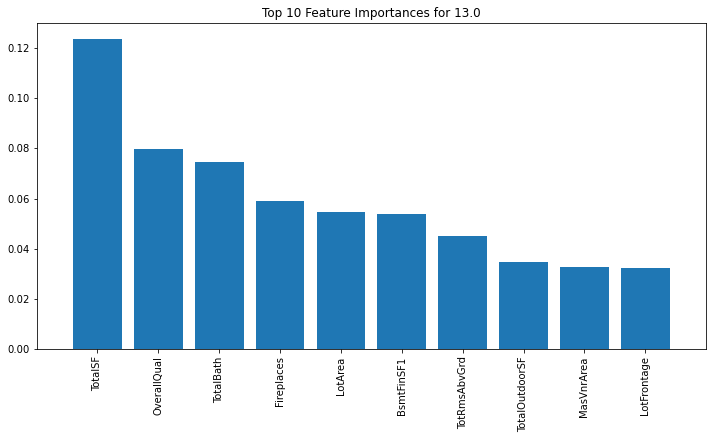

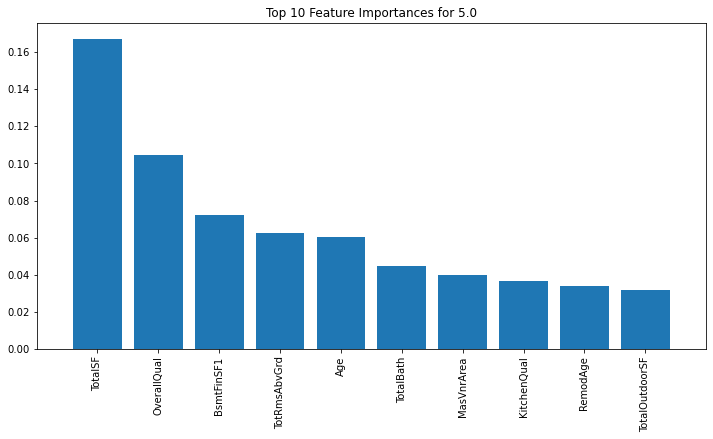

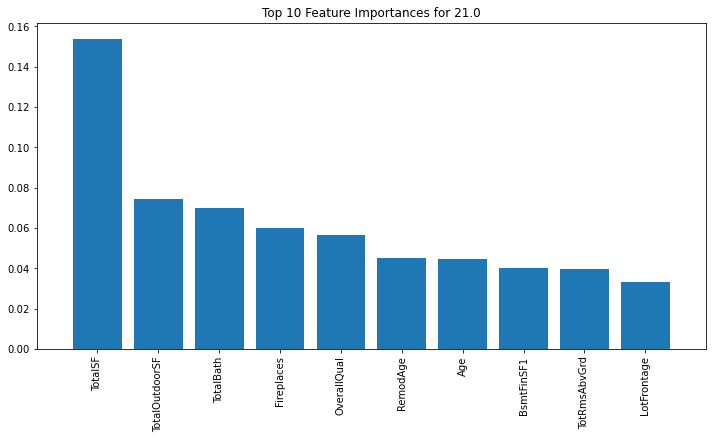

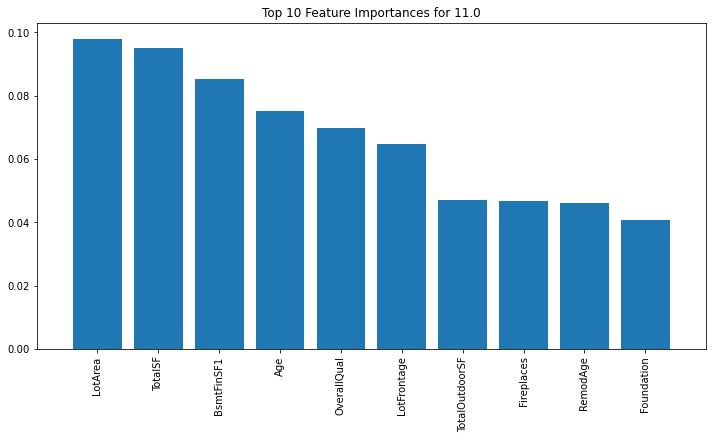

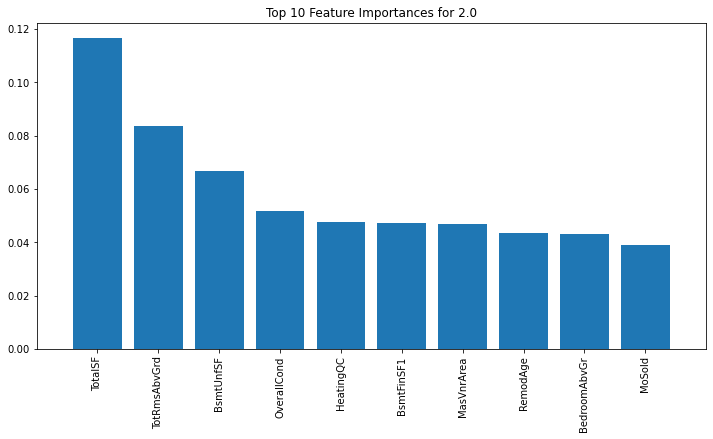

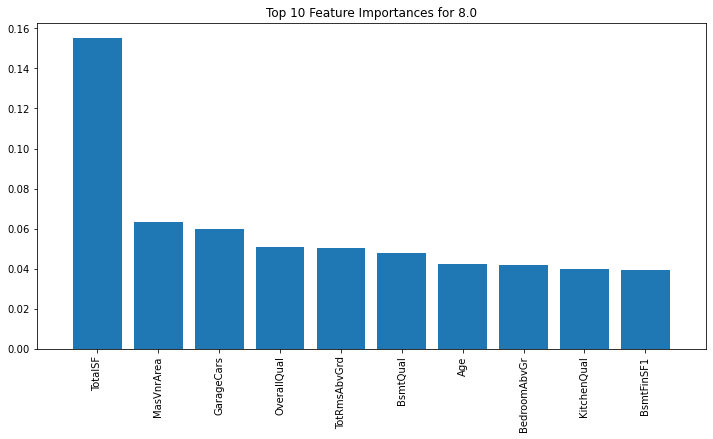

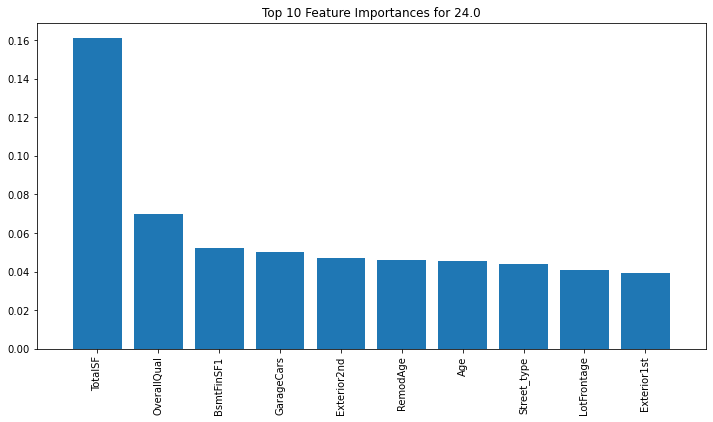

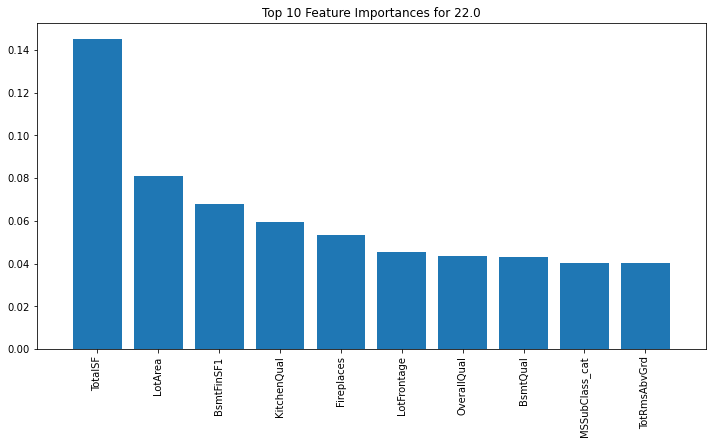

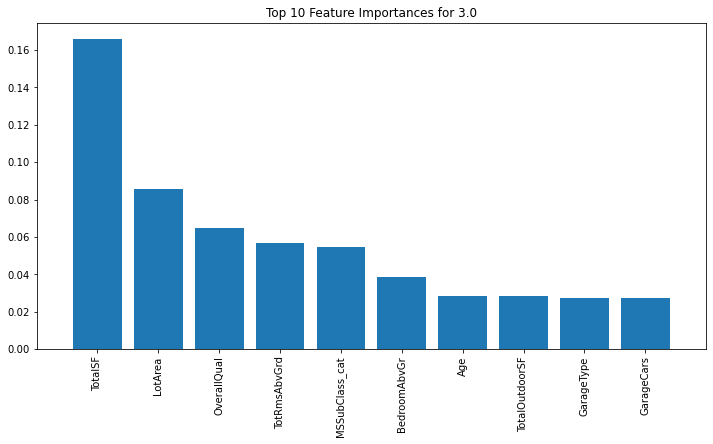

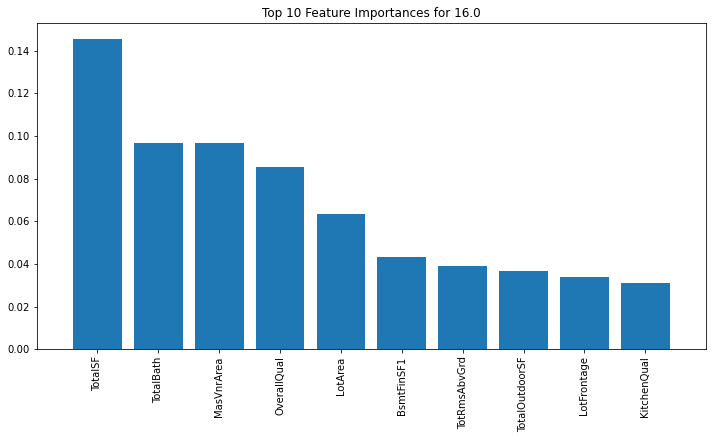

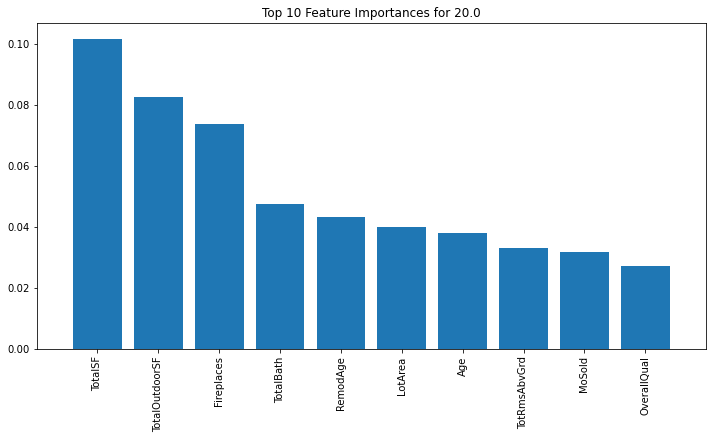

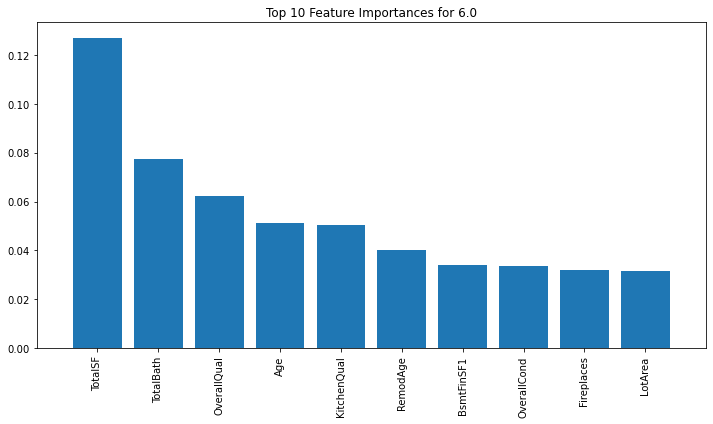

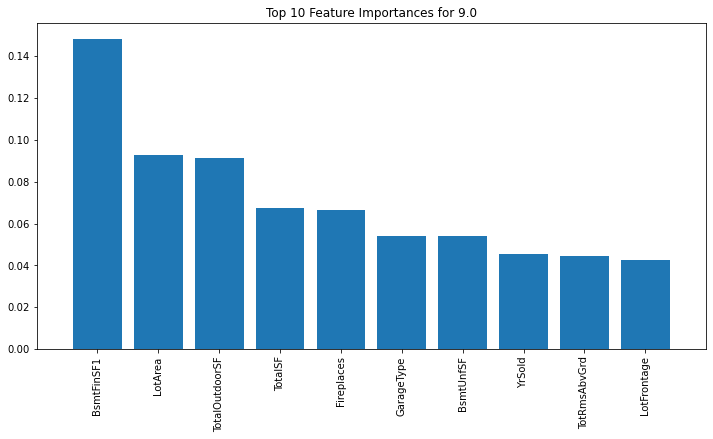

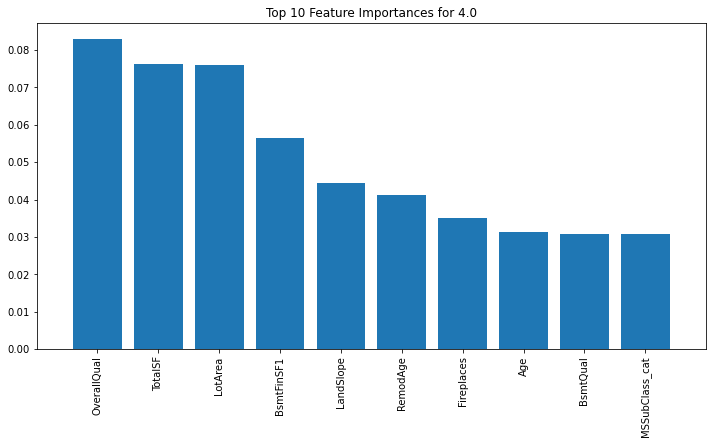

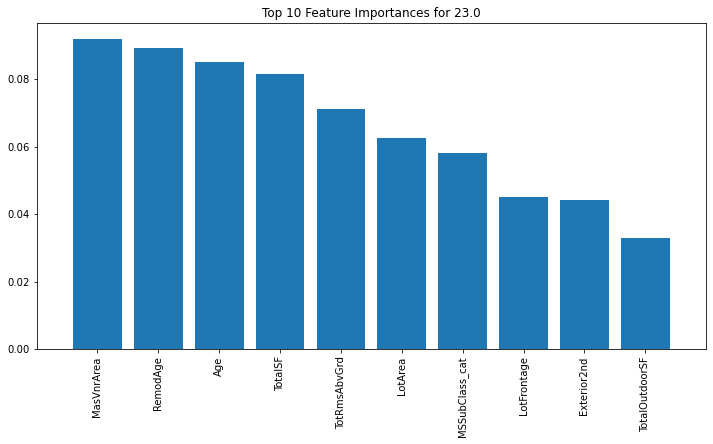

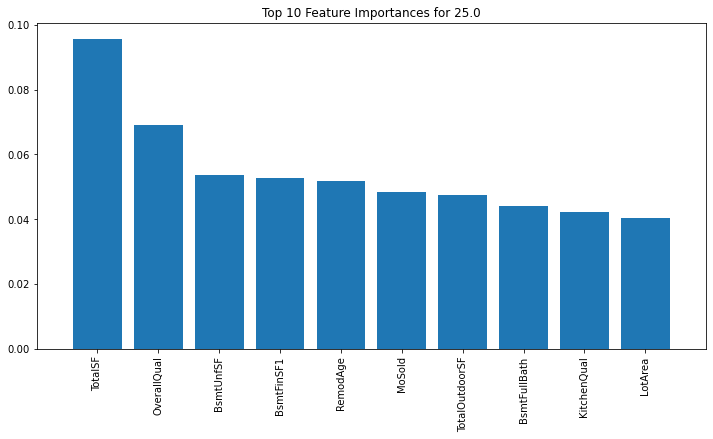

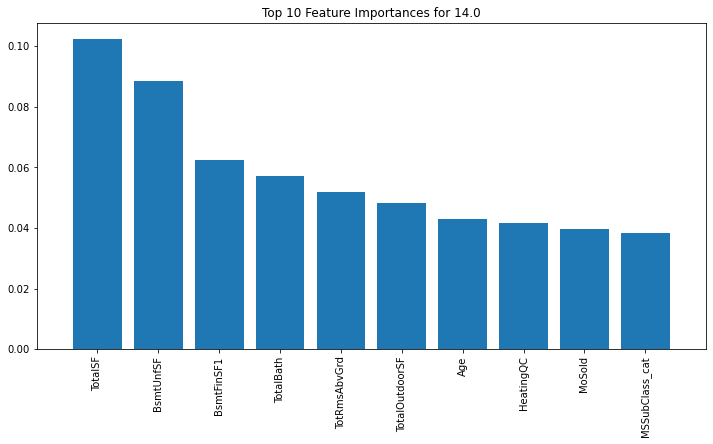

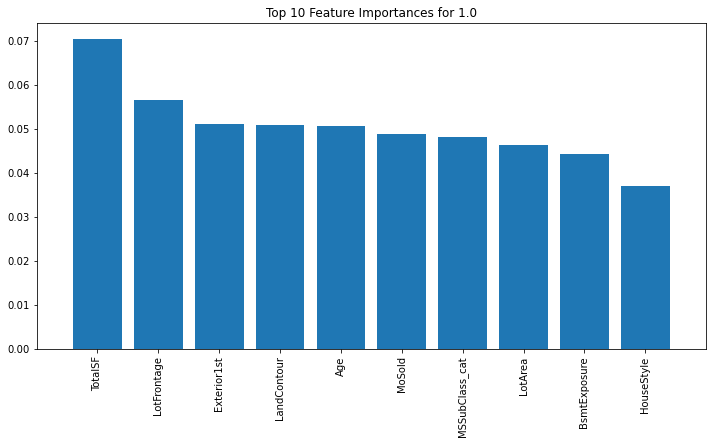

<IPython.core.display.Javascript object>

In [66]:
# top features for each neighborhood

# Split the data by neighborhood
neighborhood_data = {}
for neighborhood in housing["Neighborhood"].unique():
    neighborhood_data[neighborhood] = housing[housing["Neighborhood"] == neighborhood].drop(columns="Neighborhood")

# Train a random forest model for each neighborhood and calculate feature importances
neighborhood_importances = {}
for neighborhood, data in neighborhood_data.items():
    X_nh = data.drop(columns="SalePrice")
    y_nh = data["SalePrice"]
    
    # Train a random forest model with the best parameters
    rf_nh = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    rf_nh.fit(X_nh, y_nh)
    
    # Calculate feature importances
    importances_nh = rf_nh.feature_importances_
    neighborhood_importances[neighborhood] = importances_nh

# Display the top 10 features for each neighborhood in a bar chart
for neighborhood, importances_nh in neighborhood_importances.items():
    sorted_indices_nh = np.argsort(importances_nh)[::-1][:10]  # Get the indices of the top 10 features
    plt.figure(figsize=(12, 6))
    plt.title(f"Top 10 Feature Importances for {neighborhood}")
    plt.bar(range(10), importances_nh[sorted_indices_nh], align="center")
    plt.xticks(range(10), X_nh.columns[sorted_indices_nh], rotation=90)
    plt.xlim([-1, 10])
    plt.show()
